# Geometryczne - lab 3 - ćwiczenie 3

1. Dostosuj aplikację graficzną tak, aby można było zadawać proste wielokąty przy użyciu
myszki, z dodatkowym zapisem i odczytem podanych wielokątów. Wielokąty powinny
być zadawane w kierunku przeciwnym do ruchu wskazówek zegara.
2. Zaimplementuj procedurę sprawdzającą, czy podany wielokąt jest y-monotoniczny. W
sprawozdaniu opisz krótko tę metodę sprawdzania.
3. Zaimplementuj algorytm, który dla zadanego wielokąta będzie wyszukiwał wierzchołki
początkowe, końcowe, łączące, dzielące i prawidłowe. Wierzchołki mają zostać
odpowiednio pokolorowane zgodnie z klasyfikacją.
4. Zaimplementuj procedurę triangulacji wielokąta monotonicznego (zgodnie z
algorytmem opisanym na wykładzie). Program powinien pokazywać kolejne kroki
algorytmu (tzn. kolejne tworzone trójkąty).
5. W sprawozdaniu opisz, jak zaimplementowano struktury przechowujące wielokąt oraz
utworzoną triangulację. Uzasadnij wybór struktur.
6. Przetestuj programy na różnych zestawach danych. W sprawozdaniu napisz, jakiego
typu zestawy testowano. Uzasadnij wybór danych testujących.

### Narzędzie geometryczne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


class BetterPlot:
    def __init__(self):
        self.clear()

    def clear(self):
        self.scenes = []
        self.points = []
        self.lines = []
        return self

    def add_pts(self, *pts, c='black', s=.5):
        self.points.append(PointsCollection(pts, color=c, s=s))
        return self

    def add_lines(self, *fr_to, c='black', w=.5):
        self.lines.append(LinesCollection(fr_to, color=c, linewidth=w))
        return self

    def add_polygon(self, pts, close=True, draw_pts=True, c='black', c_p='black', w=.5, s=.5):
        self.add_lines(*[ [pts[i], pts[i-1]] for i in range(0 if close else 1, len(pts)) ], c=c, w=w)
        if draw_pts:
            self.add_pts(*pts, c=c_p, s=s)
        return self

    def add_scene(self, pts=None, lines=None):
        pts = [] if pts is None else pts
        lines = [] if lines is None else lines
        self.scenes.append(Scene(pts.copy(), lines.copy()))
        return self

    def save_scene_cls(self):
        self.scenes.append(Scene(self.points.copy(), self.lines.copy()))
        self.points = []
        self.lines = []
        return self

    def set_limits(self, xlim, ylim=None):
        ylim = xlim if ylim is None else ylim
        self.add_pts((xlim[0], ylim[0]), (xlim[1], ylim[1]), c='white', s=0)
        return self

    def set_uniform_scale(self, curr_xlim, curr_ylim):
        x_mid = (curr_xlim[1] + curr_xlim[0]) / 2
        x_span = curr_xlim[1] - x_mid
        y_mid = (curr_ylim[1] + curr_ylim[0]) / 2
        y_span = curr_ylim[1] - y_mid
        if y_span > x_span*1.5:
            x_span = y_span
        else:
            y_span = x_span
        self.add_pts((x_mid-x_span*1.5, y_mid-y_span), (x_mid+x_span*1.5, y_mid+y_span), c='white', s=0)
        return self

    def get_plot(self):
        if self.scenes:
            p = Plot(scenes=self.scenes)
        else:
            p = Plot(points=self.points, lines=self.lines)
        return p

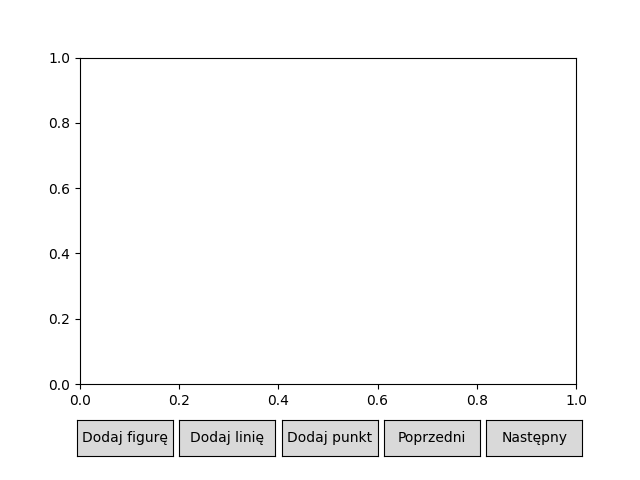

In [8]:
# setup wyświetlania, miejsce na rysowanie nowych wielokątów
b = BetterPlot()
%matplotlib widget
p = b.set_limits((-10, 10)).get_plot()
p.draw()

### Zapis, odczyt danych z narzędzia

In [3]:
import pickle

# odczyt z narzędzia
def get_drawn_polygons(p):
    rv = []
    for fig in p.get_added_figure():
        truefig = [fig.lines[0][0]]
        for _, p2 in fig.lines[:-1]:
            truefig.append(p2)
        rv.append(truefig)
    return rv


# zapis do pliku
def save_drawn_polygons(p, serialise=False, save_as=None):
    polygons = get_drawn_polygons(p)
    if serialise:
        with open(save_as if save_as is not None else 'polygons.pickle', 'wb') as f:
            pickle.dump(polygons, f)
    else:
        with open(save_as if save_as is not None else 'polygons.txt', 'w') as f:
            for polygon in polygons:
                for i, (px, py) in enumerate(polygon):
                    f.write("(%f, %f)" % px, py)
                    if i != len(polygon)-1:
                        f.write(", ")
                f.write("\n")


# odczyt z pliku
def get_polygons_from_file(filename=None, serialised=False):
    polygons = []
    if serialised:
        with open(filename if filename is not None else 'polygons.pickle', 'rb') as f:
            polygons = pickle.load(f)
    else:
        with open(filename if filename is not None else 'polygons.txt', 'r') as f:
            for line in f.readlines():
                if len(line) < 2:
                    continue
                polygon = []
                for pts_str in line.split(", ").lstrip("(").rstrip(")"):
                    p_s = pts_str.split(", ")
                    polygon.append((float(p_s[0]), float(p_s[1])))
                polygons.append(polygon)

    return polygons

### Definicje testowanych wielokątów

In [7]:
test_polys = [[(-5.411290322580646, -9.18014705882353), (-1.862903225806452, -4.259803921568627), (1.064516129032258, -9.854166666666668), (4.524193548387098, -3.3161764705882355), (0.754032258064516, -5.1360294117647065), (2.971774193548386, 7.063725490196081), (-2.306451612903226, 10.164215686274513), (-4.080645161290322, 7.333333333333336), (-7.008064516129032, 10.433823529411768), (-9.536290322580644, 5.917892156862745), (-6.69758064516129, 1.4693627450980387), (-4.346774193548386, 3.6936274509803937), (-6.209677419354838, 4.772058823529413), (-2.483870967741936, 6.254901960784316), (-1.685483870967742, 1.536764705882355), (-5.056451612903226, -2.574754901960784), (-8.693548387096774, -0.013480392156861143), (-9.491935483870968, -6.349264705882353)], [(-0.9758064516129021, 9.22058823529412), (-1.02016129032258, 2.480392156862745), (-2.39516129032258, -0.21568627450980316), (-5.056451612903226, -2.6421568627450984), (-2.528225806451612, -4.731617647058824), (-5.455645161290322, -8.506127450980392), (3.2379032258064537, -10.05637254901961), (0.7096774193548399, 7.670343137254903)], [(-1.19758064516129, 10.096813725490197), (-1.153225806451612, 4.098039215686274), (-2.306451612903226, 1.334558823529413), (-4.96774193548387, -0.9571078431372548), (-2.39516129032258, -3.450980392156863), (-5.100806451612904, -6.7536764705882355), (3.459677419354838, -9.314950980392158), (-1.02016129032258, 7.131127450980394)], [(-1.55241935483871, 9.355392156862749), (-8.782258064516128, -4.125), (-5.278225806451612, -0.8223039215686256), (-3.814516129032258, 3.019607843137255), (-2.883064516129032, 3.087009803921571), (-5.233870967741936, -2.9117647058823533), (-4.30241935483871, -4.192401960784313), (-2.39516129032258, 3.8284313725490193), (-1.064516129032258, 0.0649509803921582), (0.931451612903226, -2.776960784313726)], [(-1.685483870967742, 8.479166666666668), (-9.758064516129032, -8.10171568627451), (-4.657258064516128, -0.21568627450980316), (-6.298387096774194, -6.147058823529411), (-4.125, -1.2941176470588225), (-0.6653225806451601, -1.5637254901960773), (-2.92741935483871, -4.394607843137255), (-2.794354838709678, -7.36029411764706), (-1.5967741935483861, -3.5183823529411757), (5.810483870967742, -5.58578431372549)], [(-5.0, -5.0), (5.0, -5.0), (5.0, 5.0), (-5.0, 5.0)], [(-4.701612903225806, -7.764705882352942), (-2.883064516129032, -8.10171568627451), (2.395161290322582, -7.02328431372549), (-2.883064516129032, -5.338235294117647), (-2.794354838709678, -3.855392156862745), (2.6169354838709697, -2.2377450980392144), (-2.883064516129032, -0.8223039215686256), (-2.794354838709678, 0.930147058823529), (2.173387096774194, 2.2781862745098067), (-2.838709677419354, 3.8284313725490193), (-2.838709677419354, 5.311274509803923), (2.705645161290322, 6.120098039215687), (-2.661290322580644, 8.007352941176471), (-4.30241935483871, 8.1421568627451)], [(-7.0, -5.0), (5.0, -5.0), (-5.0, 5.0)], [(-7.540322580645161, -2.507352941176471), (-6.786290322580645, -3.922794117647058), (-5.14516129032258, -5.540441176470589), (-2.262096774193548, -6.012254901960784), (-0.3991935483870961, -5.540441176470589), (2.838709677419354, -4.125), (3.903225806451614, -1.6985294117647047), (4.479838709677418, 0.930147058823529), (3.3709677419354858, 3.8284313725490193), (1.0201612903225818, 5.917892156862745), (-1.641129032258064, 6.928921568627452), (-4.568548387096774, 6.389705882352942), (-6.564516129032258, 5.7830882352941195), (-7.584677419354839, 4.3676470588235325), (-7.939516129032258, 1.8063725490196099), (-8.205645161290324, -0.7549019607843128)], [(0.620967741935484, 9.22058823529412), (-1.508064516129032, 9.287990196078432), (-1.508064516129032, 5.7830882352941195), (-10.068548387096774, 5.5808823529411775), (-10.112903225806452, 2.5477941176470615), (-1.685483870967742, 2.4825980392156874), (-1.72983870967742, 0.1213235294117645), (-9.891129032258064, 0.05392156862745168), (-9.935483870967742, -2.776960784313726), (-1.774193548387096, -2.9117647058823533), (-1.9072580645161281, -5.675245098039216), (-9.758064516129032, -5.70563725490196), (-9.846774193548388, -7.966911764705882), (-1.951612903225806, -8.034313725490197), (-1.9072580645161281, -9.51936274509804), (0.2217741935483879, -9.584558823529413), (0.443548387096774, -7.899509803921569), (10.024193548387098, -7.60171568627451), (9.80241935483871, -4.9686274509803905), (0.48790322580645196, -4.940441176470588), (0.35483870967741993, -2.7095588235294112), (9.713709677419354, -2.4399509803921564), (9.49193548387097, 0.3235294117647065), (0.576612903225806, 0.4561274509803937), (0.310483870967742, 3.2914215686274515), (9.84677419354839, 3.356617647058826), (9.536290322580646, 6.1875), (0.26612903225806406, 6.252696078431374)], [(-0.6653225806451601, 8.276960784313726), (-7.05241935483871, -8.506127450980392), (1.286290322580646, -6.349264705882353), (-2.084677419354838, -4.125), (3.681451612903226, -2.1703431372549016), (-2.57258064516129, 1.4693627450980387), (4.834677419354838, 2.480392156862745), (1.8629032258064537, 5.446078431372552), (3.681451612903226, 6.457107843137258)], [(-3.681451612903226, 6.457107843137258), (-1.8629032258064537, 5.446078431372552), (-4.834677419354838, 2.480392156862745), (2.57258064516129, 1.4693627450980387), (-3.681451612903226, -2.1703431372549016), (2.084677419354838, -4.125), (-1.286290322580646, -6.349264705882353), (7.05241935483871, -8.506127450980392), (0.6653225806451601, 8.276960784313726)], [(-0.35483870967741815, 6.794117647058826), (-5.455645161290322, -7.36029411764706), (6.875000000000002, -0.5526960784313708), (5.36693548387097, -0.14828431372549034), (3.814516129032258, 0.4583333333333357), (2.661290322580646, 1.1997549019607838), (1.5967741935483861, 2.1433823529411775), (0.620967741935484, 3.626225490196081), (0.044354838709677935, 4.906862745098042)]]

## Algorytmy
### Sprawdzanie y-monotoniczności

In [9]:
def is_y_monotone(polygon):
    N = len(polygon)
    highest, lowest = 0, 0
    for i in range(1, N):
        if polygon[i][1] > polygon[highest][1]:
            highest = i
        if polygon[i][1] < polygon[lowest][1]:
            lowest = i

    for side in (1, -1):
        i = highest
        next = -1
        while next != lowest:
            next = i + side
            if next == N:   next = 0
            if next == -1:  next = N-1
            if polygon[next][1] > polygon[i][1]:
                return False
            i = next

    return True

In [10]:
for test_poly in test_polys:
    print(is_y_monotone(test_poly), end=' ')

False True True False False True True True True True True True True 

### Klasyfikacja wierzchołków

In [11]:
from math import fsum
from enum import Enum


def det_3x3(a, b, c):
    return fsum((a[0]*b[1], b[0]*c[1], c[0]*a[1], -c[0]*b[1], -a[0]*c[1], -b[0]*a[1]))


class VertexType(Enum):
    STARTING = 1,
    ENDING = 2,
    JOINING = 3,
    DIVIDING = 4,
    CORRECT = 5


def classify_vertices(polygon, eps=10**(-12)):
    N = len(polygon)
    result = [None for _ in polygon]

    for i in range(N):
        next = i+1 if i != N-1 else 0
        is_agg_or_div = det_3x3(polygon[i-1], polygon[i], polygon[next]) < -eps
        if polygon[i][1] > polygon[next][1] and polygon[i][1] > polygon[i-1][1]:
            vt = VertexType.DIVIDING if is_agg_or_div else VertexType.STARTING
        elif polygon[i][1] < polygon[next][1] and polygon[i][1] < polygon[i-1][1]:
            vt = VertexType.JOINING if is_agg_or_div else VertexType.ENDING
        else:
            vt = VertexType.CORRECT

        result[i] = vt

    return result

In [13]:
# Wizualizacja klasyfikacji wierzchołków
def classify_and_plot_polygon(polygon, dontclassify=False):
    COLOUR_MAPPING = {VertexType.STARTING: 'green',
                      VertexType.ENDING:   'red',
                      VertexType.JOINING:  'darkblue',
                      VertexType.DIVIDING: 'lightblue',
                      VertexType.CORRECT:  'saddlebrown'}

    vsize = 30
    b = BetterPlot()
    b.add_polygon(polygon, draw_pts=dontclassify, w=.5, s=10)
    if not dontclassify:
        cls = classify_vertices(polygon)
        for tp, clr in COLOUR_MAPPING.items():
            b.add_pts(*(polygon[i] for i, t in enumerate(cls) if t == tp), c=clr, s=vsize)
    return b.set_limits((-10, 10)).get_plot()

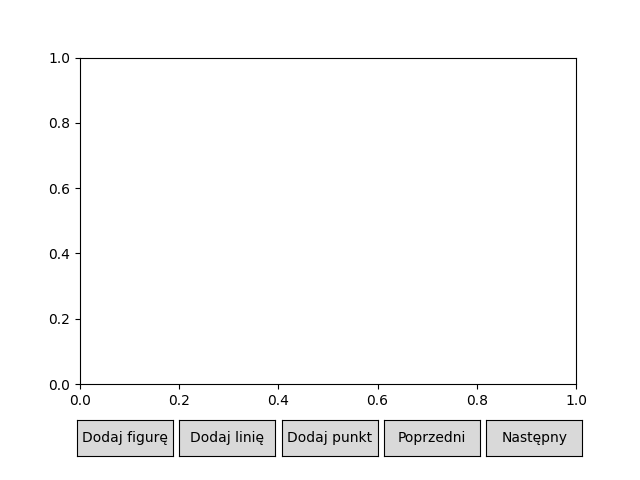

In [14]:
p = classify_and_plot_polygon(test_polys[0])
p.draw()

### Triangulacja wielokąta y-monotonicznego

In [15]:
from collections import deque


def triangulate_y_monotone_unsafe(polygon, eps=10**(-12)):
    tri = []
    events = sorted([i for i, _ in enumerate(polygon)], key=lambda i: -polygon[i][1])
    hst, lst = events[0], events[-1]
    left = (lambda i: i > hst and i < lst) if hst < lst else (lambda i: i > hst or i < lst)

    stack = deque(events[:2])
    for i in events[2:]:
        on_left_chain = left(i)
        if on_left_chain == left(stack[-1]):
            while len(stack) > 1:
                d = det_3x3(polygon[stack[-2]], polygon[stack[-1]], polygon[i])
                # trójkąt jest na zewnątrz wielokąta
                if (on_left_chain and d < -eps) or (not on_left_chain and d > eps):
                    break
                # trójkąt jest wewnątrz wielokąta
                else:
                    tri.append((stack[-2], stack[-1], i) if on_left_chain else (stack[-2], i, stack[-1]))
                    stack.pop()

            stack.append(i)
        else:
            tri.extend(( (i, stack[s+1], stack[s]) if on_left_chain else (i, stack[s], stack[s+1])
                         for s in range(len(stack)-1) ))
            stack = deque((stack[-1], i))

    return tri

# wrapper -- zanim zaczniesz liczyć, upewnij się, że jest y-monotoniczny
def triangulate_y_monotone(polygon, eps=10**(-12)):
    if not is_y_monotone(polygon):
        return []
    return triangulate_y_monotone_unsafe(polygon, eps)

# wygeneruj dodatkowo dane niezbędne do rysowania kolejnych kroków działania
def triangulate_y_monotone_with_drawing_data(polygon, drawing_data, eps=10**(-12)):
    if not is_y_monotone(polygon):
        return []

    drawing_data.clear()
    tri = []
    events = sorted([i for i, _ in enumerate(polygon)], key=lambda i: -polygon[i][1])
    hst, lst = events[0], events[-1]
    left = (lambda i: i > hst and i < lst) if hst < lst else (lambda i: i > hst or i < lst)

    stack = deque(events[:2])
    for i in events[2:]:
        on_left_chain = left(i)
        if on_left_chain == left(stack[-1]):
            while len(stack) > 1:
                drawing_data.append({'stack': list(stack), 'result': tri.copy(), 'triangle': (stack[-2], stack[-1], i)})
                d = det_3x3(polygon[stack[-2]], polygon[stack[-1]], polygon[i])
                # trójkąt jest na zewnątrz wielokąta
                if (on_left_chain and d < -eps) or (not on_left_chain and d > eps):
                    break
                # trójkąt jest wewnątrz wielokąta
                else:
                    tri.append((stack[-2], stack[-1], i) if on_left_chain else (stack[-2], i, stack[-1]))
                    stack.pop()

            stack.append(i)
        else:
            for s in range(len(stack)-1):
                drawing_data.append({'stack': list(stack), 'result': tri.copy(), 'triangle': (i, stack[s], stack[s+1])})
                tri.append((i, stack[s+1], stack[s]) if on_left_chain else (i, stack[s], stack[s+1]))
            stack = deque((stack[-1], i))

    return tri

In [16]:
# wizualizacja triangulacji
def triangulate_and_draw_y_monotone_polygon(polygon, eps=10**(-12)):
    N = len(polygon)
    consecutive = lambda i, j: abs(i-j) in (1, N-1)
    pts = lambda li: [polygon[i] for i in li]
    b = BetterPlot()
    ddata = []
    t = triangulate_y_monotone_with_drawing_data(polygon, ddata, eps)
    if len(t) == 0:
        return b.set_limits((-10, 10)).get_plot()

    for ddentry in ddata:
        b.add_polygon(polygon, s=20, w=.8)
        b.add_pts(*pts(ddentry['stack']), c='red', s=30)
        for tri in ddentry['result']:
            b.add_polygon(pts(tri), c='blue', w=1)
        b.add_polygon(pts(ddentry['triangle']), c='red', w=2)
        b.set_limits((-10, 10)).save_scene_cls()

    b.add_polygon(polygon, s=20, w=.8)
    lines = set()
    for tri in t:
        for i in range(3):
            if not consecutive(tri[i], tri[i-1]):
                lines.add((min(tri[i], tri[i-1]), max(tri[i], tri[i-1])))
    b.add_lines(*(pts(ln) for ln in lines), c='green', w=1)
    b.set_limits((-10, 10)).save_scene_cls()

    return b.get_plot()

True


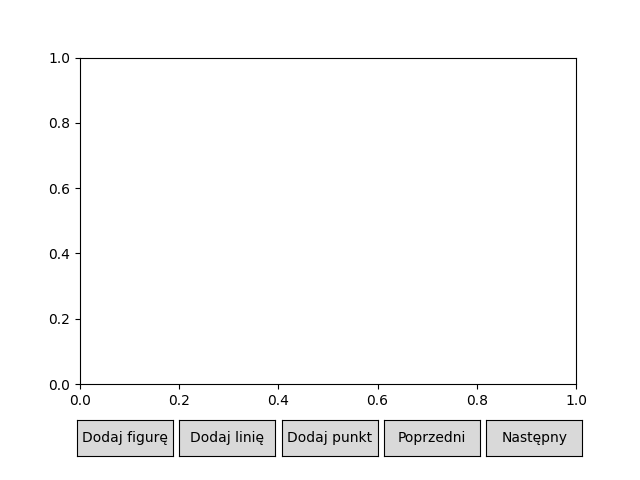

In [20]:
IND = 9
print(is_y_monotone(test_polys[IND]))
p = triangulate_and_draw_y_monotone_polygon(test_polys[IND])
p.draw()